In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import bolift
from langchain.prompts.prompt import PromptTemplate
import copy, cloudpickle
import seaborn as sns

import os
from dotenv import load_dotenv
load_dotenv()

np.random.seed(0)

/Users/maykcaldas/miniconda3/envs/bolift/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import urllib.request

urllib.request.urlretrieve(
    "https://github.com/google/fonts/raw/main/ofl/ibmplexmono/IBMPlexMono-Regular.ttf",
    "IBMPlexMono-Regular.ttf",
)
fe = font_manager.FontEntry(fname="IBMPlexMono-Regular.ttf", name="plexmono")
font_manager.fontManager.ttflist.append(fe)
plt.rcParams.update(
    {
        "axes.facecolor": "#f5f4e9",
        "grid.color": "#AAAAAA",
        "axes.edgecolor": "#333333",
        "figure.facecolor": "#FFFFFF",
        "axes.grid": False,
        "axes.prop_cycle": plt.cycler("color", plt.cm.Dark2.colors),
        "font.family": fe.name,
        "figure.figsize": (3.5, 3.5 / 1.2),
        "ytick.left": True,
        "xtick.bottom": True,
    }
)

import random

np.random.seed(0)
random.seed(0)

In [ ]:
# I saved the number of samples in the training set in the pickle file. With that, old pickle weren't compatible with the new printing format.
# This script adds a array [0 .. len(samples)] to the old pickle files, so that they are compatible with the new printing format.

d = cloudpickle.load(open("./out/<OLD_FORMAT_BO>.pkl", "rb"))

import numpy as np

data = d
for key, values in data.items():
    num_outer = values.shape[0]
    num_entries = values.shape[1]
    new_values = np.empty((num_outer, num_entries, 3), dtype='<U349')
    
    for j in range(num_outer):
        for i in range(num_entries):
            description, value = values[j, i]
            new_values[j, i] = [description, str(i+1), value]

    # Update the original dictionary with the new data format
    data[key] = new_values

cloudpickle.dump(data, open("./out/<NEW_FORMAT_BO>.pkl", "wb"))

# BayesOpt Plot

In [ ]:
def plot_BO(ax, data_file, title, data, axis_name, lim=None, data_file_random=None, label=False):
    d = cloudpickle.load(open(data_file, "rb"))
    if data_file_random:
      d_r = cloudpickle.load(open(data_file_random, "rb"))
    N=20
    M=5

    for i in range(M):
        if "expected_improvement" in d.keys():
          ax.plot(
            [int(s) for s in d['expected_improvement'][i,:N, 1]],
            [float(y) for y in d['expected_improvement'][i,:N, 2]], 
            color="C1", alpha=0.1
          )
        if "greedy" in d.keys():
           ax.plot(
            [int(s) for s in d['greedy'][i,:N, 1]],
            [float(y) for y in d['greedy'][i,:N, 2]], 
            color="C2", alpha=0.1
          )
        if "upper_confidence_bound" in d.keys():
          ax.plot(
            [int(s) for s in d['upper_confidence_bound'][i,:N, 1]],
            [float(y) for y in d['upper_confidence_bound'][i,:N, 2]], 
            color="C3", alpha=0.1
          )
        if "probability_of_improvement" in d.keys():
          ax.plot(
            [int(s) for s in d['probability_of_improvement'][i,:N, 1]],
            [float(y) for y in d['probability_of_improvement'][i,:N, 2]], 
            color="C4", alpha=0.1
          )
        if "random" in d.keys():
          ax.plot(
            [int(s) for s in d['random'][i,:N, 1]],
            [float(y) for y in d['random'][i,:N, 2]], 
            color="C5", alpha=0.1
          )
    if "expected_improvement" in d.keys():
      label = "EI" if label else None
      ax.plot(
            d['expected_improvement'][:,:N, 1].astype('int').mean(axis=0),
            d['expected_improvement'][:,:N, 2].astype('float').mean(axis=0), 
            color="C1", label=label
          )
    if "greedy" in d.keys():
      label = "Greedy" if label else None
      ax.plot(
            d['greedy'][:,:N, 1].astype('int').mean(axis=0),
            d['greedy'][:,:N, 2].astype('float').mean(axis=0), 
            color="C2", label=label
          )
    if "upper_confidence_bound" in d.keys():
      label = "UCB" if label else None
      ax.plot(
            d['upper_confidence_bound'][:,:N, 1].astype('int').mean(axis=0),
            d['upper_confidence_bound'][:,:N, 2].astype('float').mean(axis=0), 
            color="C3", label=label
          )
    if "probability_of_improvement" in d.keys():
      label = "POI" if label else None
      ax.plot(
            d['probability_of_improvement'][:,:N, 1].astype('int').mean(axis=0),
            d['probability_of_improvement'][:,:N, 2].astype('float').mean(axis=0), 
            color="C4", label=label
          )
    if "random" in d.keys():
      label = "random" if label else None
      ax.plot(
            d['random'][:,:N, 1].astype('int').mean(axis=0),
            d['random'][:,:N, 2].astype('float').mean(axis=0), 
            color="C5", label=label
          )
    if data_file_random:
      label = "Random" if label else None
      ax.plot(
            d_r['random_mean'][:, :N, 0].astype('int').mean(axis=0),
            d_r['random_mean'][:, :N, 1].astype('float').mean(axis=0), 
            color="gray", label=label, linestyle="dashed"
      )
    ax.axhline(y=data.max(), color="C15", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.max(), "max", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.quantile(0.99), color="C14", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.quantile(0.99), "99%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.quantile(0.95), color="C13", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.quantile(0.95), "95%", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.axhline(y=data.mean(), color="C12", linestyle="--")
    ax.text(ax.get_xlim()[1]+1, data.mean(), "mean", va="center", ha="left", backgroundcolor="w", fontsize=8)
    if not data_file[:3] == "sol":
      ax.axhline(y=data.quantile(0.05), color="C11", linestyle="--")
      ax.text(ax.get_xlim()[1]+1, data.quantile(0.05)+0.3, "5%", va="center", ha="left", backgroundcolor="w", fontsize=8)
      ax.axhline(y=data.min(), color="C10", linestyle="--")
      ax.text(ax.get_xlim()[1]+1, data.min()-0.3, "min", va="center", ha="left", backgroundcolor="w", fontsize=8)
    ax.set_title(title)

    ax.set_xlabel("Number of samples")
    ax.set_ylabel(f"Measured {axis_name}")
    # ax.set_xticks([i for i in range(0,N+1,5)], [str(x * 1) for x in [i for i in range(0,N+1,5)]])
    if lim:
      ax.set_ylim(lim)
    ax.set_title(title)

### C2

In [ ]:
np.random.seed(88)

data_path = "./paper/data/C2_yield_meth_oxy_short.csv"
# data_path = "./paper/data/ada_embedd_c2_dataset.csv"
raw_data = pd.read_csv(data_path, sep=";")
# raw_data = raw_data.sample(frac=1).reset_index(drop=True)

# raw_data['completion'] = - raw_data['completion']

x_name = "prompt"
y_name = "completion"



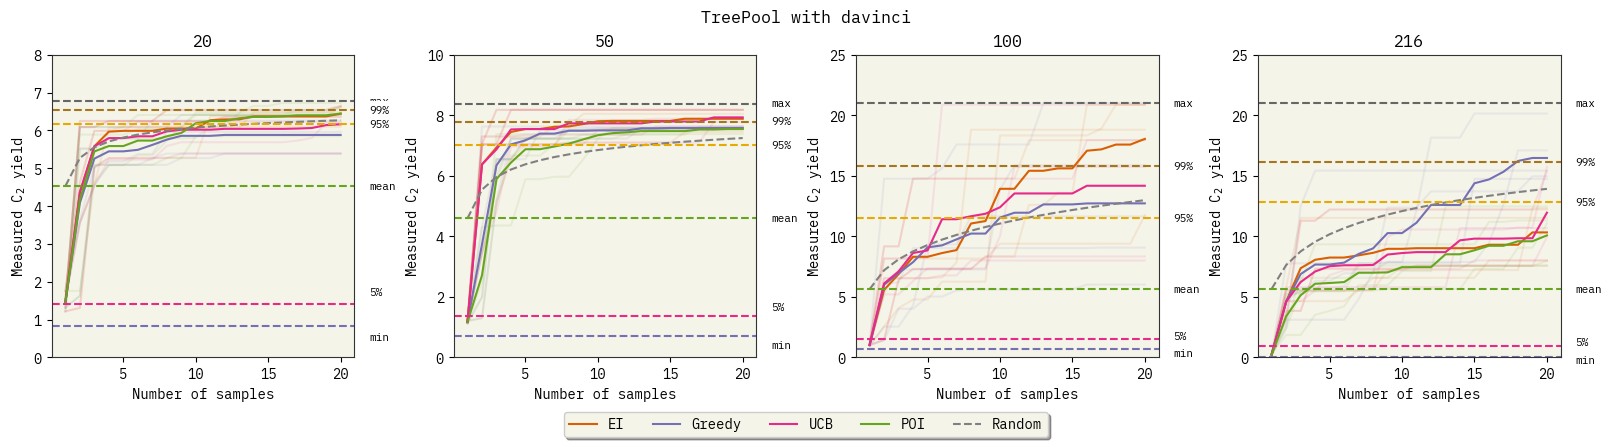

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,8)
raw_data = pd.read_csv("dataset/data/1180_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_1180_1_tree.pkl","20", 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 1180.pkl")

lim=(0,10)
raw_data = pd.read_csv("dataset/data/2950_ocm_dataset.csv", sep=";")
plot_BO(axs[1], "./out/C2_davinci_2950_1_tree.pkl","50",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 2950.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/5900_ocm_dataset.csv", sep=";")
plot_BO(axs[2], "./out/C2_davinci_5900_1_tree.pkl", "100",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 5900.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[3], "./out/C2_davinci_12744_1_tree_2.pkl", "216",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

fig.suptitle("TreePool with davinci")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    './out/C2_davinci_1180_1_tree.pkl',
    './out/C2_davinci_2950_1_tree.pkl',
    './out/C2_davinci_5900_1_tree.pkl',
    './out/C2_davinci_12744_1_tree.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for run in d['upper_confidence_bound'][:, :, 0]:
        print([r[14:r.find(",")] for r in run])
    
    print()

./out/C2_davinci_1180_1_tree.pkl
['ZSM-5', 'Pd-Na2WO4/SiO2', 'SiO2', 'SiO2', 'SiO2', 'SiO2', 'SiO2', 'SiO2', 'SiO2', 'SiO2', 'Mn-SrWO4/SiO2', 'Al2O3', 'Mn-Na2WO4/SiCnf', 'SiCnf', 'Y-Na2WO4/SiO2', 'Mn-Na2WO4/TiO2', 'Mn-K2WO4/SiO2', 'Mn-Na2WO4/Nb2O5', 'TiO2', 'Mn-Na2WO4/SiCnf']
['ZSM-5', 'Mn-Na2WO4/Al2O3', 'Cu-Na2WO4/SiO2', 'Na2WO4/SiO2', 'Ce-Na2WO4/SiO2', 'Mn-Na2WO4/SiCnf', 'Nb2O5', 'Na/SiO2', 'Mn-Na2WO4/SiCnf', 'Cu-Na2WO4/SiO2', 'Ce-Na2WO4/SiO2', 'SiCnf', 'Mn-Na2WO4/BN', 'BN', 'Cu-Na2WO4/SiO2', 'WOx/SiO2', 'SiO2', 'SiO2', 'SiO2', 'Cu-Na2WO4/SiO2']
['WOx/SiO2', 'Mn-Na2WO4/BN', 'Fe-Na2WO4/SiO2', 'Mn-Na2WO4/BEA', 'Mn-Na2WO4/BN', 'BN', 'Mn-Na2WO4/BN', 'Mn-Na2WO4/BN', 'Mn-Na2WO4/BN', 'Mn-Na2WO4/BN', 'Mn-Na2WO4/SiO2', 'Pd-Na2WO4/SiO2', 'SiCnf', 'Na/SiO2', 'Co-Na2WO4/SiO2', 'Mn-Na2WO4/ZSM-5', 'Mn-Na2WO4/Al2O3', 'Fe-Na2WO4/SiO2', 'Fe-Na2WO4/SiO2', 'Fe-Na2WO4/SiO2']
['Pd-Na2WO4/SiO2', 'Mn-Na2WO4/TiO2', 'BEA', 'Mn-Na2WO4/BN', 'Mn-Na2WO4/SiC', 'Mn-Na2WO4/BN', 'BN', 'SiC', 'Mn-Na2WO4/BN', 'Mn-Na2W

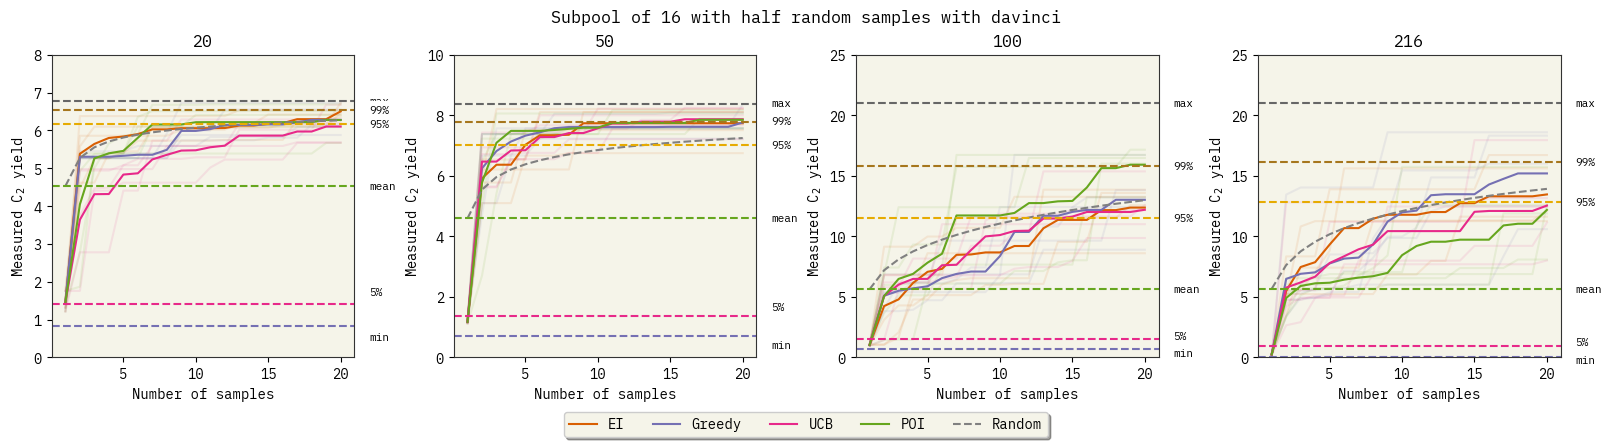

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,8)
raw_data = pd.read_csv("dataset/data/1180_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_1180_1_16hh.pkl","20", 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 1180.pkl")

lim=(0,10)
raw_data = pd.read_csv("dataset/data/2950_ocm_dataset.csv", sep=";")
plot_BO(axs[1], "./out/C2_davinci_2950_1_16hh.pkl","50",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 2950.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/5900_ocm_dataset.csv", sep=";")
plot_BO(axs[2], "./out/C2_davinci_5900_1_16hh.pkl", "100",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 5900.pkl")

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[3], "./out/C2_davinci_12744_1_16hh.pkl", "216",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")
         

fig.suptitle("Subpool of 16 with half random samples with davinci")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    './out/C2_davinci_1180_1_16hh.pkl',
    './out/C2_davinci_2950_1_16hh.pkl',
    './out/C2_davinci_5900_1_16hh.pkl',
    './out/C2_davinci_12744_1_16hh.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for run in d['upper_confidence_bound'][:, :, 0]:
        print([r[14:r.find(",")] for r in run])
    
    print()

./out/C2_davinci_1180_1_16hh.pkl
['ZSM-5', 'ZSM-5', 'Mn-K2WO4/SiO2', 'ZSM-5', 'SiO2', 'Mn-Na2WO4/ZrO2', 'Mn-Na2WO4/SiO2', 'Mn-K2WO4/SiO2', 'Mn-K2MoO4/SiO2', 'Mn-K2MoO4/SiO2', 'Mn-K2MoO4/SiO2', 'Co-Na2WO4/SiO2', 'Al2O3', 'Mn-Li2MoO4/SiO2', 'Cu-Na2WO4/SiO2', 'ZrO2', 'Mn-SrWO4/SiO2', 'SiO2', 'Blank', 'Mn-MoOx/SiO2']
['ZSM-5', 'Y-Na2WO4/SiO2', 'SiC', 'ZrO2', 'SiO2', 'Al2O3', 'Al2O3', 'Nb2O5', 'Blank', 'Co-Na2WO4/SiO2', 'Mn-Na2WO4/BN', 'Co-Na2WO4/SiO2', 'Y-Na2WO4/SiO2', 'BEA', 'SiO2', 'ZSM-5', 'SiC', 'Hf-Na2WO4/SiO2', 'CeO2', 'Ni-Na2WO4/SiO2']
['WOx/SiO2', 'Nb2O5', 'Mn-Na2WO4/SiO2', 'Mn-FeMoO4/SiO2', 'SiO2', 'TiO2', 'TiO2', 'Pd-Na2WO4/SiO2', 'Al2O3', 'Ti-Na2WO4/SiO2', 'Co-Na2WO4/SiO2', 'BEA', 'Mn-FeMoO4/SiO2', 'Mn-ZnMoO4/SiO2', 'Ti-Na2WO4/SiO2', 'Na2WO4/SiO2', 'Co-Na2WO4/SiO2', 'Ni-Na2WO4/SiO2', 'Fe-Na2WO4/SiO2', 'V-Na2WO4/SiO2']
['Pd-Na2WO4/SiO2', 'SiO2', 'CeO2', 'WOx/SiO2', 'SiO2', 'Al2O3', 'TiO2', 'ZrO2', 'Nb2O5', 'Blank', 'Na/SiO2', 'SiO2', 'SiCnf', 'ZrO2', 'SiCnf', 'Tb-Na2WO4/SiO2', 'T

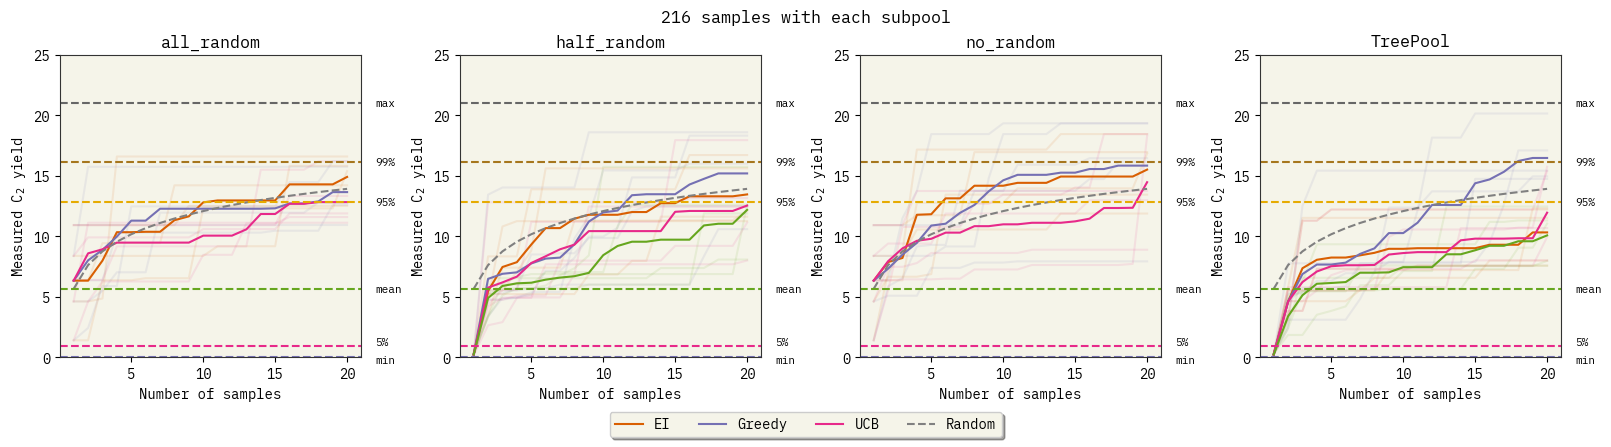

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)

lim=(0,25)
raw_data = pd.read_csv("dataset/data/12744_ocm_dataset.csv", sep=";")
plot_BO(axs[0], "./out/C2_davinci_fulldataset_new_subpool_16_allrandom_1init.pkl","all_random",
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[1], "./out/C2_davinci_12744_1_16hh.pkl","half_random",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[2], "./out/C2_davinci_fulldataset_subpool_16_no_random_1_init.pkl", "no_random",
# plot_BO(axs[2], "./out/C2_davinci_fulldataset_subpool_16_no_random_newest_seed0_2_init.pkl", "no_random",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")

plot_BO(axs[3], "./out/C2_davinci_12744_1_tree_2.pkl", "TreePool",
         raw_data[y_name], "C$_2$ yield", lim, label=False, data_file_random="./out/C2 - random - 12744.pkl")
         

fig.suptitle("216 samples with each subpool")
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
pools = [
    # './out/C2_davinci_fulldataset_new_subpool_16_allrandom_1init.pkl',
    # './out/C2_davinci_12744_1_16hh.pkl',
    # './out/C2_davinci_fulldataset_subpool_16_no_random_1_init.pkl',
    './out/C2_davinci_fulldataset_subpool_16_no_random_newest_seed0_2_init.pkl',
    # './out/C2_davinci_12744_1_tree.pkl',
]
for p in pools:
    print(p)
    d = cloudpickle.load(open(p, "rb"))
    for k in d.keys():
        for run in d[k][:, :, 0]:
            print(k, [r[14:r.find(",")] for r in run])
    
    print()

./out/C2_davinci_fulldataset_subpool_16_no_random_newest_seed0_2_init.pkl
random [' Mn-BaWO4/SiO2 ', ' Mn-Na/SiO2 ', ' Na/SiO2 ', ' ZrO2 ', ' Ni-Na2WO4/SiO2 ', ' Mn-MoOx/SiO2 ', ' Mn-MgWO4/SiO2 ', ' Mn-ZnMoO4/SiO2 ', ' TiO2 ', ' Na2WO4/SiO2 ', ' Ce-Na2WO4/SiO2 ', ' Fe-Na2WO4/SiO2 ', ' Mn-Na2WO4/Al2O3 ', ' Mn-MoOx/SiO2 ', ' Na2WO4/SiO2 ', ' Mn-MoOx/SiO2 ', ' Mn-FeMoO4/SiO2 ', ' Mn-Na2WO4/ZSM-5 ', ' Mn-Na2WO4/ZSM-5 ', ' Zn-Na2WO4/SiO2 ']
random [' Mn-SrWO4/SiO2 ', ' Y-Na2WO4/SiO2 ', ' CeO2 ', ' Mn-FeMoO4/SiO2 ', ' Eu-Na2WO4/SiO2 ', ' Mn-Na2WO4/CeO2 ', ' Mn-Na2WO4/SiO2 ', ' Zr-Na2WO4/SiO2 ', ' Mn-MoOx/SiO2 ', ' MgO ', ' Mn-BaWO4/SiO2 ', ' Mn-MoOx/SiO2 ', ' Zr-Na2WO4/SiO2 ', ' Mn-WOx/SiO2 ', ' BN ', ' WOx/SiO2 ', ' Zr-Na2WO4/SiO2 ', ' Mn-Na2WO4/ZrO2 ', ' Nd-Na2WO4/SiO2 ', ' Al2O3 ']
random [' BN ', ' Mn-Na2WO4/SiCnf ', ' Mn-Li2WO4/SiO2 ', ' Zr-Na2WO4/SiO2 ', ' Mn-K2MoO4/SiO2 ', ' Mn-Li2WO4/SiO2 ', ' Mn-K2MoO4/SiO2 ', ' Mn-FeMoO4/SiO2 ', ' Al2O3 ', ' SiO2 ', ' SiO2 ', ' SiCnf ', ' Mn-Li2WO4

[15.62 19.15 16.14 18.23 16.79]
DaVinci is top66: 17.186
[13.11 16.14 15.18 17.94 16.14]
Gpt4 is top172: 15.702000000000002
[18.88 18.88 18.88 18.88 18.88]
GPR is top13: 18.88


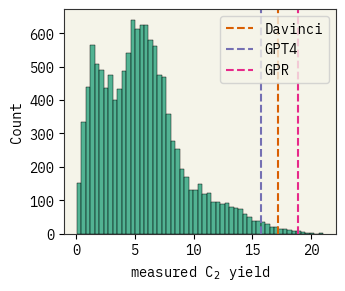

                                                  prompt  completion
737     To synthesize Mn-Na2WO4/SiO2 , SiO2 (1.0 g) w...       18.60
739     To synthesize Mn-Na2WO4/SiO2 , SiO2 (1.0 g) w...       17.25
740     To synthesize Mn-Na2WO4/SiO2 , SiO2 (1.0 g) w...       19.43
745     To synthesize Mn-Na2WO4/SiO2 , SiO2 (1.0 g) w...       21.03
746     To synthesize Mn-Na2WO4/SiO2 , SiO2 (1.0 g) w...       20.88
...                                                  ...         ...
5100    To synthesize Ti-Na2WO4/SiO2 , SiO2 (1.0 g) w...       17.56
5929    To synthesize Ni-Na2WO4/SiO2 , SiO2 (1.0 g) w...       17.66
11545   To synthesize Na2WO4/SiO2 , SiO2 (1.0 g) was ...       18.71
11546   To synthesize Na2WO4/SiO2 , SiO2 (1.0 g) was ...       17.95
11580   To synthesize Na2WO4/SiO2 , SiO2 (1.0 g) was ...       17.58

[66 rows x 2 columns]


In [ ]:
d_davinci = cloudpickle.load(open("paper/out/C2_davinci_100.pkl", "rb"))
print(d_davinci['expected_improvement'][:, -1, 1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

d_gpt4 = cloudpickle.load(open("paper/out/C2_GPT4_100.pkl", "rb"))
print(d_gpt4['upper_confidence_bound'][:, -1, 1].astype(float))
best_gpt4 = d_gpt4['upper_confidence_bound'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

d_gpr = cloudpickle.load(open("paper/out/C2_GPR_100.pkl", "rb"))
print(d_gpr['expected_improvement'][:, -1, 1].astype(float))
best_gpr = d_gpr['upper_confidence_bound'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
# print(np.sum(raw_data[y_name] > best))
plt.xlabel("measured C$_2$ yield")
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_C2", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci])



### iupac-sol

In [ ]:
np.random.seed(0)
data_path = "paper/data/esol_iupac.csv"
raw_data = pd.read_csv(data_path)
raw_data = raw_data.dropna()
raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
raw_data = raw_data.sample(frac=1).reset_index(drop=True)

# raw_data['measured log(solubility:mol/L)'] = -raw_data['measured log(solubility:mol/L)']
x_name = "IUPAC"
y_name = "measured log(solubility:mol/L)"

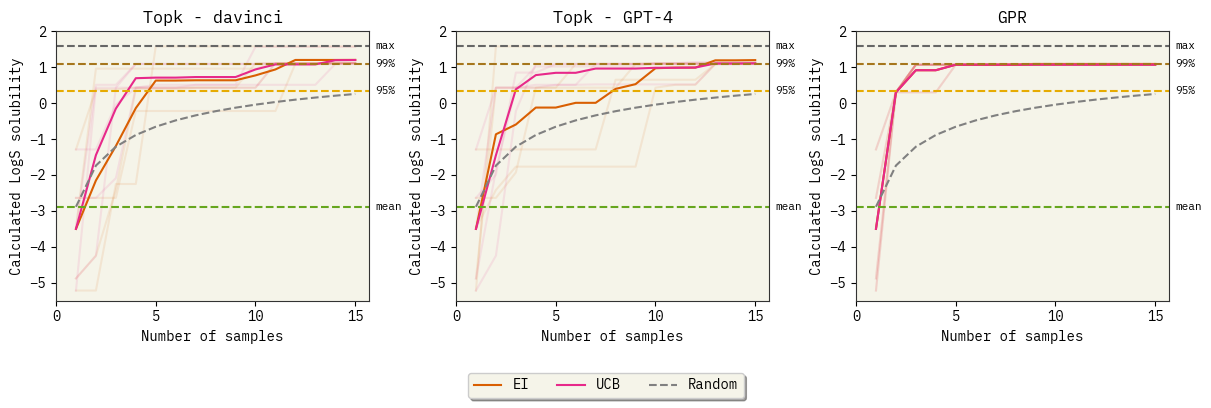

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4), constrained_layout=True)
for ax in axs.flat:
    ax.set_aspect(1.8)

lim=(-5.5,2)

plot_BO(axs[0], "paper/out/sol_davinci_100.pkl", "Topk - davinci",
         raw_data[y_name], "LogS solubility", lim, label=False, data_file_random="paper/out/sol - random.pkl")
plot_BO(axs[1], "paper/out/sol_gpt4_100.pkl", "Topk - GPT-4",
         raw_data[y_name], "LogS solubility", lim, label=False, data_file_random="paper/out/sol - random.pkl")
plot_BO(axs[2], "paper/out/sol_GPR_100.pkl", "GPR",
         raw_data[y_name], "LogS solubility", lim, label=True, data_file_random="paper/out/sol - random.pkl")

fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_sol", dpi=300, bbox_inches='tight')
plt.show()

[1.11 1.58 1.11 1.11 1.11]
DaVinci is top3: 1.2040000000000002
[1.12 1.58 1.09 1.09 1.11]
Gpt4 is top3: 1.198
[1.07 1.1  1.07 1.07 1.1 ]
GPR is top10: 1.082


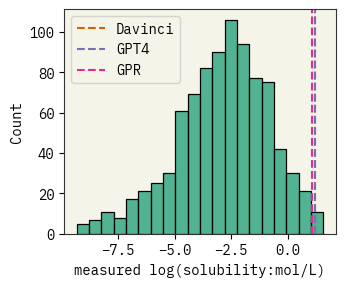

                                                 IUPAC  \
32   2-(2-dimethoxyphosphorylsulfanylethylsulfanyl)...   
36                                           acetamide   
151                                    methylhydrazine   
834                                           methanol   

     measured log(solubility:mol/L)  
32                            1.144  
36                            1.580  
151                           1.340  
834                           1.570  


In [ ]:
d_davinci = cloudpickle.load(open("paper/out/sol_davinci_100.pkl", "rb"))
d_gpt4 = cloudpickle.load(open("paper/out/sol_gpt4_100.pkl", "rb"))
d_gpr = cloudpickle.load(open("paper/out/sol_GPR_100.pkl", "rb"))

print(d_davinci['expected_improvement'][:, -1, 1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

print(d_gpt4['expected_improvement'][:, -1, 1].astype(float))
best_gpt4 = d_gpt4['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"Gpt4 is top{np.sum(raw_data[y_name] > best_gpt4)}: {best_gpt4}")

print(d_gpr['expected_improvement'][:, -1, 1].astype(float))
best_gpr = d_gpr['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(f"GPR is top{np.sum(raw_data[y_name] > best_gpr)}: {best_gpr}")

sns.histplot(raw_data[y_name])
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.axvline(best_gpt4, color='C2', linestyle='--', label="GPT4")
plt.axvline(best_gpr, color='C3', linestyle='--', label="GPR")
plt.legend()
plt.savefig(f"figs/hist_sol", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci-0.08])



# BayesOpt experiments

In [ ]:
import uncertainty_toolbox as uct

def combine(s, l):
  '''Number of combinations of l elements with max = s'''
  return (s**l - (s-1)**(l))

def prob(s, l, n):
  '''Probability of getting a sample with max([x0,x1,...,xl]) = s where xi={0,n}'''
  return combine(s,l) * ((1/n)**l)

def expected_value_p(l, n):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  E = [s * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

def expected_value_q(l, n, data):
  '''Expected value of max([x0,x1,...,xl]) where xi={0,n}'''
  quants = [data.quantile(i/100) for i in range(100+1)]
  # E = [(quants[s-1]) * prob(s, l, n) for s in range(1,100+1)]
  E = [((quants[s-1]+quants[s])/2) * prob(s, l, n) for s in range(1,100+1)]
  return sum(E)

from tenacity import (
    retry,
    stop_after_attempt,
    wait_random_exponential,
)

@retry(wait=wait_random_exponential(min=1, max=60), stop=stop_after_attempt(6))
def run_experiment(
    asktell, pool, raw_data, indexes, x_name, y_name, N=10, initial_train=1, ask_K=1, aq="random", start_index=0, calibrate=False
):
    if aq=='random_mean':
       return [ (i, expected_value_q(i, 100, raw_data[y_name])) for i in range(1,N+1) ]
    for i in indexes[:initial_train]:
        asktell.tell(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))
    if calibrate:
        # y = [float(raw_data[y_name].iloc[i]) for i in indexes[:initial_train]]
        # pred = asktell.predict(y)
        # ymeans = np.array([yhi.mean() for yhi in pred])
        # ystds = np.array([yhi.std() for yhi in pred])
        # calibration_factor = uct.recalibration.optimize_recalibration_ratio(ymeans, ystds, np.array(y), criterion="miscal")
        calibration_factor = 5.0
        asktell.set_calibration_factor(calibration_factor)

    # x = [raw_data[x_name].iloc[i] for i in indexes]
    x = raw_data[x_name].tolist()

    pool.reset()
    xi = x[start_index]
    x.remove(xi)
    pool.choose(xi)
    yi = float(raw_data[raw_data[x_name] == xi][y_name].iloc[0])
    asktell.tell(xi, yi)
    point = [(xi, initial_train, yi, yi)]
    best = point[0][-1]
    for i in range(1, N):
        if i == N - 1 and aq != "random":
            aq = "greedy"
        px, _, py = asktell.ask(pool, 
                                k=ask_K, 
                                aq_fxn=aq, 
                                _lambda=1.0, 
                                inv_filter=16,
                                aug_random_filter=0,
                                )
        for j in range(ask_K):
          xc = px[j]
          x.remove(xc)
          pool.choose(xc)
          y = float(raw_data[raw_data[x_name] == xc][y_name].iloc[0])
          asktell.tell(xc, y)
          best = max(y, best)
        point.append((xc, initial_train+i*ask_K, best, y))
    return point

### in-house

In [ ]:
def get_asktell():
  return bolift.AskTellFewShotTopk(
    # prefix="You are a bot who knows chemistry and catalysts. " \
    #       "Below, you'll see examples of experimental procedures to synthesize catalysts and the measured CO STY in a oxidative methane coupling reaction. " \
    #       "The following question should be answered with a number and finished with ###\n",
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    x_formatter=lambda x: f"experimental procedure: {x}",
    y_name="C2 yield",
    y_formatter=lambda y: f"{y:.2f}",
    # model="text-curie-001",
    model="text-davinci-003",
    # model="gpt-4",
    selector_k=5,
    temperature=0.7,
  )

In [ ]:
np.random.seed(0)
data_path = "./dataset/data/71023_BO_ready_pool.csv"
path_random = "./out/in-house - random - 42000.pkl"
# template:    db_model_dbFilter_initial_pool
path = "./out/in-house_davinci_42000_1_14nr2r_points.pkl"
pool_path = "./dataset/data/42000_in-house_pool.pkl"

initial_train = 0
ask_K = 1
raw_data = pd.read_csv(data_path)

raw_data['Catalyst'] = raw_data['Prompt'].str.extract(r'(\b[A-Z][a-z]?:[A-Z][a-z]?:[A-Z][a-z]?\b)')
unique_cat = raw_data['Catalyst'].unique()
c = {c: 0.2+m*(5/len(unique_cat)) for m, c in enumerate(unique_cat)}
raw_data['dummy_Completion'] = raw_data['Catalyst'].apply(lambda x: np.random.normal(c[x], 0.05))

N = raw_data.shape[0]
indexes = np.random.choice(raw_data.shape[0], int(N), replace=False)
x_name = "Prompt"
y_name = "dummy_Completion"
print(N, len(indexes))

if os.path.exists(pool_path):
  with open(pool_path, "rb") as f:
    pool = cloudpickle.load(f)
  pool.reset()
else:
  x = [raw_data[x_name].iloc[i] for i in indexes]
  pool = bolift.Pool(list(x), formatter=lambda x: f"experimental procedure: {x}")
  cloudpickle.dump(pool, open(pool_path, "wb"))

N = 20
M = 5
starts = raw_data.sort_values(by=y_name, ascending=True).head(100).sample(M)# np.random.randint(0, len(indexes), M)
print(starts)
starts = starts.index
print(starts)


42000 42000
                                                  Prompt  Completion  \
25207  2.0 g of Fe:Ni:Zn(1:10:5)/ZrO2 catalyst is pro...         NaN   
19621  2.0 g of Fe:Ni:Zn(10:5:5)/MgO catalyst is prod...         NaN   
35006  2.0 g of Fe:Ni:Zn(1:10:1)/Al2O3 catalyst is pr...         NaN   
32209  2.0 g of Fe:Ni:Zn(5:1:1)/ZrO2 catalyst is prod...         NaN   
9817   2.0 g of Fe:Ni:Zn(10:1:1)/TiO2 (rutile) cataly...         NaN   

       Catalyst  dummy_Completion  
25207  Fe:Ni:Zn          0.117423  
19621  Fe:Ni:Zn          0.128967  
35006  Fe:Ni:Zn          0.123826  
32209  Fe:Ni:Zn          0.094579  
9817   Fe:Ni:Zn          0.130724  
Index([25207, 19621, 35006, 32209, 9817], dtype='int64')


In [ ]:
if os.path.exists(path):
    bayesOpts_random = cloudpickle.load(open(path_random, "rb")) #random_mean
    bayesOpts = cloudpickle.load(open(path, "rb"))
else:
    bayesOpts = {}

for aq in ['random', 'expected_improvement']: #["random", "expected_improvement", "greedy", 'upper_confidence_bound', 'probability_of_improvement']:
    print(aq, "start:", end=" ")
    points = []
    for i in range(M):
        asktell = get_asktell()
        print(i, end=",  ")
        point = run_experiment(
            copy.deepcopy(asktell),
            copy.deepcopy(pool),
            raw_data,
            indexes,
            x_name,
            y_name,
            N=N,
            aq=aq,
            start_index=starts[i],
            calibrate=True,
            initial_train=initial_train,
            ask_K=ask_K
        )
        points.append(point)
    points = np.array(points)
    bayesOpts[aq] = points
    print(aq, "done")
    # asktell.save_cache("GPR_ada_embed_cache.csv")
    cloudpickle.dump(bayesOpts, open(path, "wb"))
cloudpickle.dump(bayesOpts, open(path, "wb"))


random start: 0,  1,  2,  3,  4,  random done
expected_improvement start: 0,  

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 250000 / min. Current: 232313 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 250000 / min. Current: 224316 / min. Contact us through our help center at help.openai.com if you continue to have issues..


1,  

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 250000 / min. Current: 213454 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 250000 / min. Current: 212774 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 250000 /

2,  

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 250000 / min. Current: 230740 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 250000 / min. Current: 213343 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 250000 /

3,  

Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 250000 / min. Current: 241088 / min. Contact us through our help center at help.openai.com if you continue to have issues..
Retrying langchain.llms.openai.completion_with_retry.<locals>._completion_with_retry in 4.0 seconds as it raised RateLimitError: Rate limit reached for default-text-davinci-003 in organization org-zVzDC0J6UhWoGf9pmQAfuLud on tokens per min. Limit: 250000 / min. Current: 234135 / min. Contact us through our help center at help.openai.com if you continue to have issues..


4,  expected_improvement done


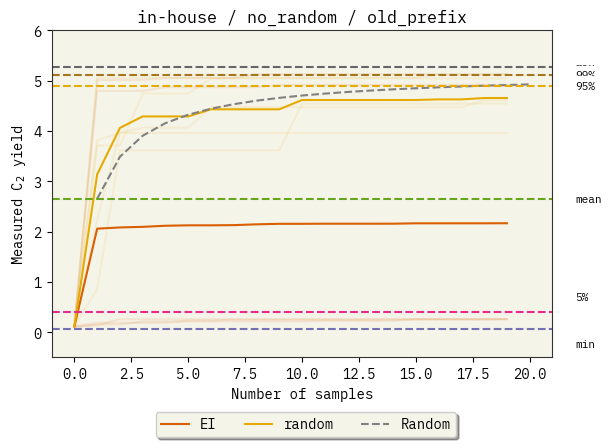

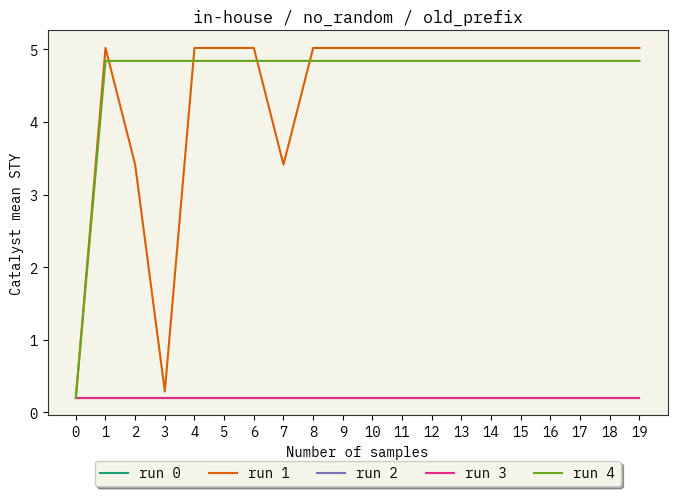

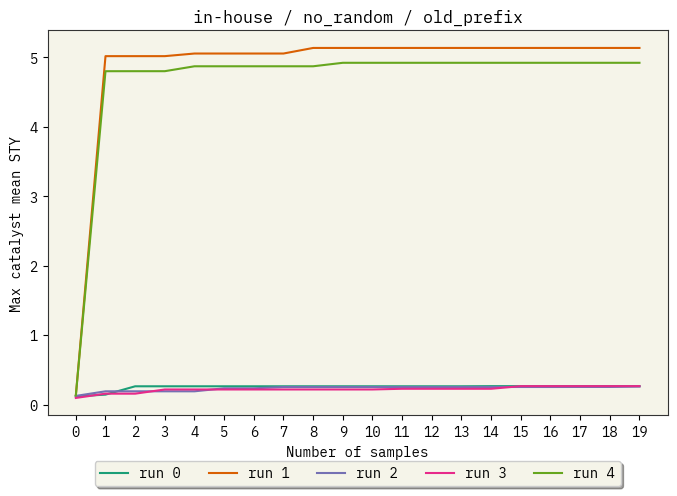

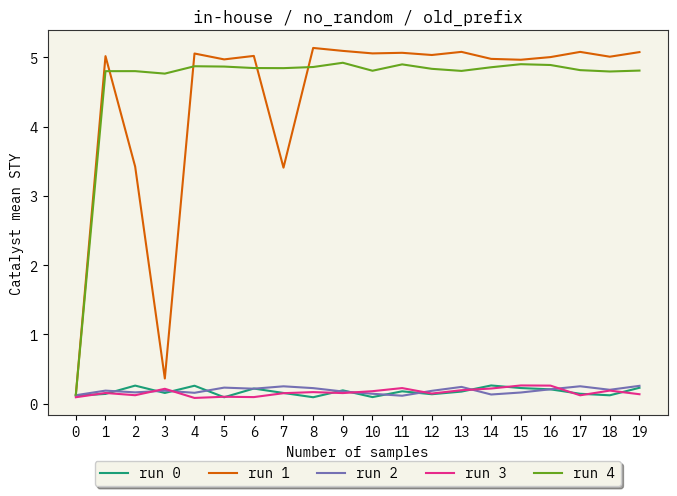

In [ ]:
#Debugging plots
import re
path="./out/in-house_davinci_42000_0_14nr2r_points.pkl"
title = "in-house / no_random / old_prefix"
d = cloudpickle.load(open(path, "rb"))

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)
lim=(-0.5, 6)
plot_BO(axs, path, title, 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random=path_random)
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()


plt.figure(figsize=(8,5))
plt.xlabel("Number of samples")
plt.ylabel("Catalyst mean STY")
plt.title(title)
for i in range(5):
    cats = [re.search(r'(\b[A-Z][a-z]?:[A-Z][a-z]?:[A-Z][a-z]?\b)',k).group(0) for k in d['expected_improvement'][i, :, 0]]
    cats_ndx = [c[cat] for cat in cats]
    plt.plot(d['expected_improvement'][i,:,1], cats_ndx, label=f"run {i}")
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()


plt.figure(figsize=(8,5))
plt.xlabel("Number of samples")
plt.ylabel("Max catalyst mean STY")
plt.title(title)
for i in range(5):
    plt.plot(d['expected_improvement'][i,:,1], d['expected_improvement'][i, :, 2].astype(float), label=f"run {i}")
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()

plt.figure(figsize=(8,5))
plt.xlabel("Number of samples")
plt.ylabel("Catalyst mean STY")
plt.title(title)
for i in range(5):
    plt.plot(d['expected_improvement'][i,:,1], d['expected_improvement'][i, :, 3].astype(float), label=f"run {i}")
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()


In [ ]:
x_name, y_name = "Prompt", "Completion"
raw_data_w_label = raw_data.dropna()
asktell = get_asktell()
asktell.tell(raw_data_w_label[x_name].iloc[0], float(raw_data_w_label[y_name].iloc[0]))
asktell.ask(pool, k=5, aq_fxn="expected_improvement", _lambda=1.0, inv_filter=16, aug_random_filter=0)

(['2.0 g of Fe:Ni:Cu(1:1:10)/SiO2 catalyst is produced by impregnating 1.9 g of SiO2 with iron(iii) nitrate nonahydrate (0.0083 g, 0.149 mmol Fe), nickel(ii) nitrate hexahydrate (0.0083 g, 0.142 mmol Ni), copper(ii) nitrate hydrate (0.0833 g, 1.311 mmol Cu). The impregnated sample is heated to 90 °C, dried for four hours, then calcined at 450 °C for an additional four hours. A 25.0 mg portion of the calcined sample is pretreated at 450 °C for two hours under a flow of H2 (20 mL/min), then used for CO2 hydrogenation at 275 °C with a CO2/H2/Ar mixture (22.2%/66.7%/11.1%) flowing at 45 mL/min.',
  '2.0 g of Fe:Ni:Cu(1:1:10)/SiO2 catalyst is produced by impregnating 1.9 g of SiO2 with iron(iii) nitrate nonahydrate (0.0083 g, 0.149 mmol Fe), nickel(ii) nitrate hexahydrate (0.0083 g, 0.142 mmol Ni), copper(ii) nitrate hydrate (0.0833 g, 1.311 mmol Cu). The impregnated sample is heated to 90 °C, dried for four hours, then calcined at 450 °C for an additional four hours. A 50.0 mg portion of t

In [ ]:
import numpy as np
import re
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.callbacks import get_openai_callback
from langchain.cache import InMemoryCache
import langchain
from dataclasses import dataclass

from langchain.schema import HumanMessage, SystemMessage

np.random.seed(0)
data_path = "./dataset/data/71023_BO_ready_pool.csv"
path_random = "./out/in-house - random - 42000.pkl"
# template:    db_model_dbFilter_initial_pool
path = "./out/in-house_davinci_42000_0_16nr_pref.pkl"
pool_path = "./dataset/data/42000_in-house_pool.pkl"
initial_train = 1
ask_K = 1
raw_data = pd.read_csv(data_path)
N = raw_data.shape[0]
indexes = np.random.choice(raw_data.shape[0], int(N), replace=False)
x_name = "Prompt"
y_name = "dummy_Completion"

asktell=get_asktell()

raw_data['Catalyst'] = raw_data['Prompt'].str.extract(r'(\b[A-Z][a-z]?:[A-Z][a-z]?:[A-Z][a-z]?\b)')
unique_cat = raw_data['Catalyst'].unique()
c = {c: 0.2+m*(5/len(unique_cat)) for m, c in enumerate(unique_cat)}
raw_data['dummy_Completion'] = raw_data['Catalyst'].apply(lambda x: np.random.normal(c[x], 0.05))

print(N, len(indexes))
for i in starts[1:2]:
    print(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))
    asktell.tell(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))

def wrap_chatllm(query_list, llm):
    if type(llm) == ChatOpenAI:
        system_message_prompt = SystemMessage(
            content="You are a bot that can predict chemical and material properties. Do not explain answers, just provide numerical predictions."
        )
        if type(query_list) == str:
            query_list = [system_message_prompt, HumanMessage(content=query_list)]
        else:
            query_list = [
                [system_message_prompt, HumanMessage(content=q)] for q in query_list
            ]
    return query_list

# asktell.inv_predict(y=15)
query = asktell.inv_prompt.format(
            y=asktell.format_y(15.0), y_name=asktell._y_name, x_name=asktell._x_name
    )

print(query)
print()

print(
    asktell.inv_llm(
        wrap_chatllm(query, asktell.inv_llm)
        )
    )

# print(asktell.prompt.format(x=asktell.format_x("a given procedure"), y_name=asktell._y_name))

42000 42000
2.0 g of Fe:Ni:Zn(10:5:5)/MgO catalyst is produced by impregnating 1.9 g of MgO with iron(iii) nitrate nonahydrate (0.0500 g, 0.895 mmol Fe), nickel(ii) nitrate hexahydrate (0.0250 g, 0.426 mmol Ni), zinc nitrate hexahydrate (0.0250 g, 0.382 mmol Zn). The impregnated sample is heated to 90 °C, dried for four hours, then calcined at 450 °C for an additional four hours. A 150.0 mg portion of the calcined sample is pretreated at 450 °C for two hours under a flow of H2 (20 mL/min), then used for CO2 hydrogenation at 275 °C with a CO2/H2/Ar mixture (22.2%/66.7%/11.1%) flowing at 45 mL/min. 0.16848520594820285
You are a bot who knows chemistry and catalysts. Below, you'll see examples of the measured CO STY in a oxidative methane coupling reaction and the experimental procedures to synthesize the catalyst associated to that conversion. You should use the given context to generate another procedure with the desired STY. You should change the catalyst and reaction setup as much as 

### C2

In [ ]:
# asktell = bolift.AskTellFewShotMulti(
#   x_formatter=lambda x: f"experimental procedure: {x}",
#   y_name="C2 yield",
#   y_formatter=lambda y: f"{y:.2f}",
#   model="text-curie-001",
#   selector_k=5,
#   temperature=0.05
# )

asktell = bolift.AskTellFewShotTopk(
  prefix="You are a bot who knows chemistry and catalysts. " \
        "Below, you'll see examples of experimental procedures to synthesize catalysts and the measured C2 yield in a oxidative methane coupling reaction. " \
        "The following question should be answered with a number and finished with ###\n",
  prompt_template=PromptTemplate(
      input_variables=["x", "y", "y_name"],
      template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
  ),
  suffix="What is the {y_name} of {x}?@@@\nA:",
  x_formatter=lambda x: f"experimental procedure: {x}",
  y_name="C2 yield",
  y_formatter=lambda y: f"{y:.2f}",
  # model="text-curie-001",
  model="text-davinci-003",
  # model="gpt-4",
  selector_k=5,
  temperature=0.7,
)

# asktell = bolift.AskTellGPR(
#   prefix="The following question should be answered with a number\n",
#   prompt_template=PromptTemplate(
#       input_variables=["x", "y", "y_name"],
#       template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
#   ),
#   suffix="What is the {y_name} of {x}?@@@\nA:",
#   x_formatter=lambda x: f"experimental procedure: {x}",
#   y_name="C2 yield",
#   y_formatter=lambda y: f"{y:.2f}",
#   model='text-ada-001',
#   pool=bolift.Pool([raw_data[x_name].iloc[i] for i in range(1000)], formatter=lambda x: f"experimental procedure: {x}"),
#   n_components=32,
#   # cache_path="GPR_ada_embed_cache.csv"
# )

# asktell = bolift.AskTellRidgeKernelRegression(
#     prefix="The following question should be answered with a number\n",
#     prompt_template=PromptTemplate(
#         input_variables=["x", "y", "y_name"],
#         template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
#     ),
#     suffix="What is the {y_name} of {x}?@@@\nA:",
#     x_formatter=lambda x: f"iupac name {x}",
#     y_name="measured log solubility in mols per litre",
#     y_formatter=lambda y: f"{y:.2f}",
#     model="text-ada-001",
#     alpha=0.5
#   )

In [ ]:
np.random.seed(88)

data_path = "./dataset/data/12744_ocm_dataset.csv"

path_random = "./out/C2 - random - 12744.pkl"
# template:    db_model_dbFilter_initial_pool
path = "./out/C2_davinci_12744_1_16nr_points.pkl"
pool_path = "./dataset/data/12744_ocm_pool.pkl"

initial_train = 1
ask_K = 1

raw_data = pd.read_csv(data_path, sep=";")

# raw_data['completion'] = - raw_data['completion']

N = raw_data.shape[0]
indexes = np.random.choice(raw_data.shape[0], int(N), replace=False)
x_name = "prompt"
y_name = "completion"
print(N, len(indexes))

if os.path.exists(pool_path):
  with open(pool_path, "rb") as f:
    pool = cloudpickle.load(f)
  pool.reset()
else:
  x = [raw_data[x_name].iloc[i] for i in indexes]
  pool = bolift.Pool(list(x), formatter=lambda x: f"experimental procedure: {x}")
  cloudpickle.dump(pool, open(pool_path, "wb"))

N = 20
M = 5
starts = raw_data.sort_values(by=y_name, ascending=True).head(100).sample(M)# np.random.randint(0, len(indexes), M)
print(starts)
starts = starts.index
print(starts)


12708 12708
                                                  prompt  completion
3884   To synthesize Mn-BaWO4/SiO2, SiO2 (1.0 g) was ...        0.28
3665   To synthesize Mn-SrWO4/SiO2, SiO2 (1.0 g) was ...        0.35
9070   To synthesize BN, BN (1.0 g) was impregnated w...        0.36
10793  To synthesize TiO2, TiO2 (1.0 g) was impregnat...        0.17
3880   To synthesize Mn-BaWO4/SiO2, SiO2 (1.0 g) was ...        0.23
Index([3884, 3665, 9070, 10793, 3880], dtype='int64')


In [ ]:
if os.path.exists(path):
    bayesOpts_random = cloudpickle.load(open(path_random, "rb")) #random_mean
    bayesOpts = cloudpickle.load(open(path, "rb"))
else:
    bayesOpts = {}

for aq in ['random', 'expected_improvement']: #["random", "expected_improvement", "greedy", 'upper_confidence_bound', 'probability_of_improvement']:
    print(aq, "start:", end=" ")
    points = []
    for i in range(M):
        print(i, end=",  ")
        point = run_experiment(
            copy.deepcopy(asktell),
            copy.deepcopy(pool),
            raw_data,
            indexes,
            x_name,
            y_name,
            N=N,
            aq=aq,
            start_index=starts[i],
            calibrate=True,
            initial_train=initial_train,
            ask_K=ask_K
        )
        points.append(point)
    points = np.array(points)
    bayesOpts[aq] = points
    print(aq, "done")
    # asktell.save_cache("GPR_ada_embed_cache.csv")
    cloudpickle.dump(bayesOpts, open(path, "wb"))
cloudpickle.dump(bayesOpts, open(path, "wb"))


random start: 0,  1,  2,  3,  4,  random done
expected_improvement start: 0,  1,  2,  3,  4,  expected_improvement done


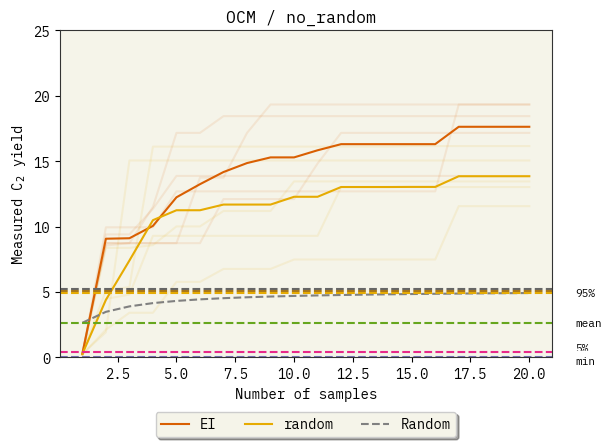

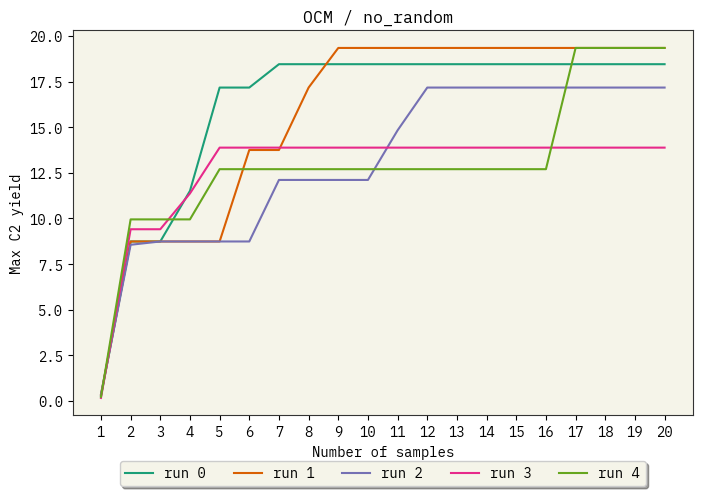

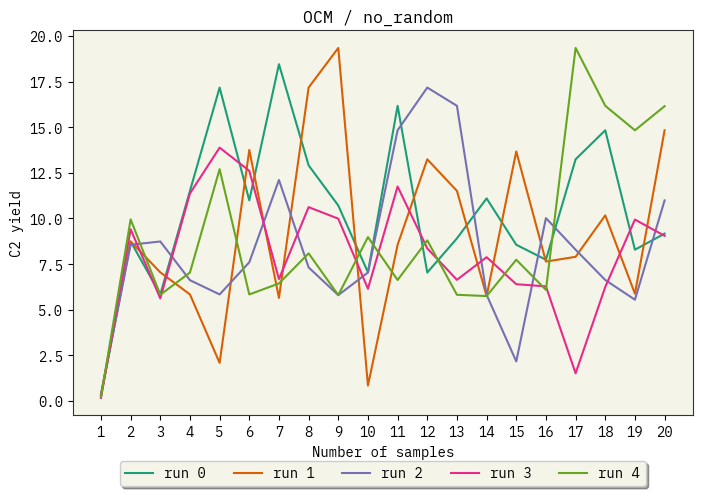

In [ ]:
#Debugging plots
import re
path="./out/C2_davinci_12744_1_16nr_points.pkl"
title = "OCM / no_random "
d = cloudpickle.load(open(path, "rb"))

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(6,4), constrained_layout=True)
# for ax in axs.flat:
#     ax.set_aspect(0.6)
lim=(0, 25)
plot_BO(axs, path, title, 
         raw_data[y_name], "C$_2$ yield", lim, label=True, data_file_random=path_random)
fig.legend(loc='upper center', bbox_to_anchor=(0.5,0),
          fancybox=True, shadow=True, ncol=6)
plt.savefig(f"figs/BO_C2", dpi=300, bbox_inches='tight')
plt.show()

plt.figure(figsize=(8,5))
plt.xlabel("Number of samples")
plt.ylabel("Max C2 yield")
plt.title(title)
for i in range(5):
    plt.plot(d['expected_improvement'][i,:,1], d['expected_improvement'][i, :, 2].astype(float), label=f"run {i}")
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()

plt.figure(figsize=(8,5))
plt.xlabel("Number of samples")
plt.ylabel("C2 yield")
plt.title(title)
for i in range(5):
    plt.plot(d['expected_improvement'][i,:,1], d['expected_improvement'][i, :, 3].astype(float), label=f"run {i}")
plt.legend(loc='upper center', bbox_to_anchor=(0.5,-0.1),
          fancybox=True, shadow=True, ncol=5)
plt.show()


[ 8.62  9.02  9.31 15.56 18.71 16.08 14.81 13.03 10.86  9.87]
DaVinci is top700: 12.587000000000002


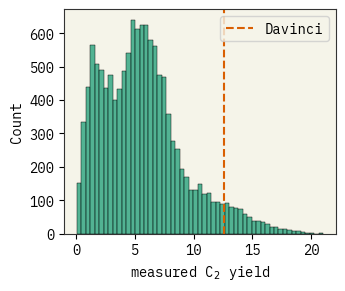

                                                  prompt  completion
728    To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       13.59
730    To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       13.24
731    To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       16.48
734    To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       12.59
736    To synthesize Mn-Na2WO4/SiO2, SiO2 (1.0 g) was...       13.88
...                                                  ...         ...
11606  To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was im...       13.44
11607  To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was im...       14.66
11608  To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was im...       12.81
11610  To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was im...       13.33
11616  To synthesize Na2WO4/SiO2, SiO2 (1.0 g) was im...       13.11

[700 rows x 2 columns]


In [ ]:
import seaborn as sns

d_davinci = cloudpickle.load(open(path, "rb"))
print(d_davinci['expected_improvement'][:, -1, -1].astype(float))
best_davinci = d_davinci['expected_improvement'][:, :, -1].astype(float).mean(axis=0)[-1]
print(f"DaVinci is top{np.sum(raw_data[y_name] > best_davinci)}: {best_davinci}")

sns.histplot(raw_data[y_name])
# print(np.sum(raw_data[y_name] > best))
plt.xlabel("measured C$_2$ yield")
plt.axvline(best_davinci, color='C1', linestyle='--', label="Davinci")
plt.legend()
plt.savefig(f"figs/hist_C2", dpi=300, bbox_inches='tight')
plt.show()

print(raw_data[raw_data[y_name] > best_davinci])



In [ ]:
d = cloudpickle.load(open(path, "rb"))
for k in range(5):
    print([k[14:k.find(",")] for k in d['expected_improvement'][k, :, 0]])

In [ ]:
import numpy as np
import re
from langchain.llms import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.callbacks import get_openai_callback
from langchain.cache import InMemoryCache
import langchain
from dataclasses import dataclass

from langchain.schema import HumanMessage, SystemMessage

np.random.seed(0) # 88
data_path = "./dataset/data/C2_yield_meth_oxy_short.csv"
path_random = "./out/C2 - random - 12744.pkl"
path = "./out/C2_davinci_12744_1_16hh.pkl"
pool_path = "./dataset/data/12744_ocm_pool.pkl"
initial_train = 1
ask_K = 1
# raw_data = pd.read_csv(data_path, sep=";")
raw_data = pd.read_csv(data_path)
N = raw_data.shape[0]
indexes = np.random.choice(raw_data.shape[0], int(N), replace=False)
x_name = "prompt"
y_name = "completion"
print(N, len(indexes))
for i in starts[1:2]:
    print(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))
    asktell.tell(raw_data[x_name].iloc[i], float(raw_data[y_name].iloc[i]))

def wrap_chatllm(query_list, llm):
    if type(llm) == ChatOpenAI:
        system_message_prompt = SystemMessage(
            content="You are a bot that can predict chemical and material properties. Do not explain answers, just provide numerical predictions."
        )
        if type(query_list) == str:
            query_list = [system_message_prompt, HumanMessage(content=query_list)]
        else:
            query_list = [
                [system_message_prompt, HumanMessage(content=q)] for q in query_list
            ]
    return query_list

# asktell.inv_predict(y=15)
query = asktell.inv_prompt.format(
            y=asktell.format_y(15.0), y_name=asktell._y_name, x_name=asktell._x_name
    )

print(query)
print()

print(
    asktell.inv_llm(
        wrap_chatllm(query, asktell.inv_llm)
        )
    )

# print(asktell.prompt.format(x=asktell.format_x("a given procedure"), y_name=asktell._y_name))

### IUPAC-Solubility

In [ ]:
np.random.seed(0)

data_path = "paper/data/esol_iupac.csv"
raw_data = pd.read_csv(data_path)
raw_data = raw_data.dropna()
raw_data = raw_data[["IUPAC", "measured log(solubility:mol/L)"]]
raw_data = raw_data.sample(frac=1).reset_index(drop=True)

# raw_data['measured log(solubility:mol/L)'] = -raw_data['measured log(solubility:mol/L)']

print(raw_data.columns)

N = raw_data.shape[0]
indexes = [i for i in range(N)]  # np.random.choice(raw_data.shape[0], int(N), replace=False)
x_name = "IUPAC"
y_name = "measured log(solubility:mol/L)"
print(len(raw_data), len(indexes))

asktell = bolift.AskTellFewShotTopk(
  prefix="",
  prompt_template=PromptTemplate(
      input_variables=["x", "y", "y_name"],
      template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
  ),
  suffix="What is the {y_name} of {x}?@@@\nA:",
  x_formatter=lambda x: f"iupac name {x}",
  y_name="measured log solubility in mols per litre",
  y_formatter=lambda y: f"{y:.2f}",
  model="text-davinci-003",
  selector_k=5,
  temperature=0.7,
)

# asktell = bolift.AskTellFewShotMulti(
#     x_formatter=lambda x: f"iupac name {x}",
#     y_name="measured log solubility in mols per litre",
#     y_formatter=lambda y: f"{y:.2f}",
#     model="text-curie-001",
#     selector_k=5,
#     temperature=0.05
# )

# asktell = bolift.AskTellGPR(
#   prefix="The following question should be answered with a number\n",
#   prompt_template=PromptTemplate(
#       input_variables=["x", "y", "y_name"],
#       template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
#   ),
#   suffix="What is the {y_name} of {x}?@@@\nA:",
#   x_formatter=lambda x: f"iupac name {x}",
#   y_name="measured log solubility in mols per litre",
#   y_formatter=lambda y: f"{y:.2f}",
#   model='text-ada-001',
#   pool=bolift.Pool(raw_data[x_name].to_list(), formatter=lambda x: f"iupac name {x}"),
#   n_components=16,
# )

Index(['IUPAC', 'measured log(solubility:mol/L)'], dtype='object')
882 882


In [ ]:
x = [raw_data[x_name].iloc[i] for i in indexes]
path_random = "paper/out/sol - random.pkl"
path = "paper/out/sol_davinci_100.pkl"
pool_path = "paper/out/sol_pool.pkl"

if os.path.exists(pool_path):
  with open(pool_path, "rb") as f:
    pool = cloudpickle.load(f)
  pool.reset()
else:
  x = [raw_data[x_name].iloc[i] for i in indexes]
  pool = bolift.Pool(list(x), formatter=lambda x: f"experimental procedure: {x}")
  cloudpickle.dump(pool, open(pool_path, "wb"))

N = 15
M = 5
starts = np.random.randint(0, len(indexes), M)
# starts = [110, 374, 790, 365, 523, 119, 560, 199, 239, 694, 608, 850, 599, 405, 510, 514, 264, 266, 261, 294, 612]
# print([raw_data[y_name].iloc[i] for i in starts])

In [ ]:
if os.path.exists(path):
    bayesOpts_random = cloudpickle.load(open(path_random, "rb"))
    bayesOpts = cloudpickle.load(open(path, "rb"))
else:
    bayesOpts = {}

for aq in ["random", "expected_improvement", "greedy", 'upper_confidence_bound', 'probability_of_improvement']:
    print(aq, "start:", end=" ")
    points = []
    for i in range(M):
        print(i, end=",  ")
        point = run_experiment(
            copy.deepcopy(asktell),
            copy.deepcopy(pool),
            raw_data,
            indexes,
            x_name,
            y_name,
            N=N,
            aq=aq,
            start_index=starts[i],
            calibrate=True,
            initial_train=100
        )
        points.append(point)
    # plot mean
    points = np.array(points)
    bayesOpts[aq] = points
    print(aq, "done")
    # asktell.save_cache("GPR_ada_embed_cache.csv")
    cloudpickle.dump(bayesOpts, open(path, "wb"))

cloudpickle.dump(bayesOpts, open(path, "wb"))

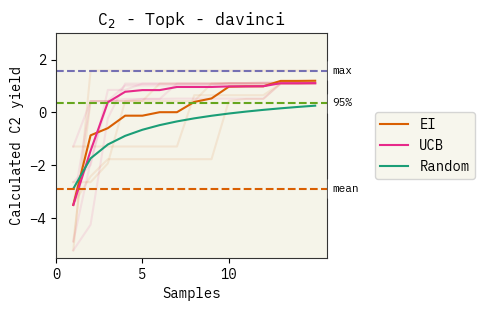

In [ ]:
d = cloudpickle.load(open(path, "rb"))
d_r = cloudpickle.load(open(path_random, "rb"))
N=15
M=5

plt.figure(figsize=(3.5, 3.5 / 1.2))
for i in range(M):
    plt.plot(range(1, N + 1), [float(y) for x, y in d['expected_improvement'][i,:N]], color="C1", alpha=0.1)
    plt.plot(range(1, N + 1), [float(y) for x, y in d['greedy'][i,:N]], color="C2", alpha=0.1)
    plt.plot(range(1, N + 1), [float(y) for x, y in d['upper_confidence_bound'][i,:N]], color="C3", alpha=0.1)
    plt.plot(range(1, N + 1), [float(y) for x, y in d['probability_of_improvement'][i,:N]], color="C4", alpha=0.1)
    plt.plot(range(1, N + 1), [float(y) for x, y in d['random'][i,:N]], color="C0", alpha=0.1)
plt.plot(
    range(1, N + 1), d['expected_improvement'][:, :N, 1].astype(float).mean(axis=0), color="C1", label="EI"
)
plt.plot(
    range(1, N + 1), d['greedy'][:, :N, 1].astype(float).mean(axis=0), color="C2", label="Greedy",
)
plt.plot(
    range(1, N + 1), d['upper_confidence_bound'][:, :N, 1].astype(float).mean(axis=0), color="C3", label="UCB",
)
plt.plot(
    range(1, N + 1), d['probability_of_improvement'][:, :N, 1].astype(float).mean(axis=0), color="C4", label="POI",
)
plt.plot(
    range(1, N + 1), d_r['random_mean'][:, :N, 1].astype(float).mean(axis=0), color="C0", label="Random",
)
plt.axhline(y=raw_data[y_name].max(), color="C2", linestyle="--")
plt.text(N + 1, raw_data[y_name].max(), "max", va="center", ha="left", backgroundcolor="w", fontsize=8)
plt.axhline(y=raw_data[y_name].quantile(0.95), color="C4", linestyle="--")
plt.text(N + 1, raw_data[y_name].quantile(0.95), "95%", va="center", ha="left", backgroundcolor="w", fontsize=8)
plt.axhline(y=raw_data[y_name].mean(), color="C1", linestyle="--")
plt.text(N + 1, raw_data[y_name].mean(), "mean", va="center", ha="left", backgroundcolor="w", fontsize=8)
# plt.axhline(y=raw_data[y_name].quantile(0.05), color="C3", linestyle="--")
# plt.text(N + 1, raw_data[y_name].quantile(0.05)+0.3, "5%", va="center", ha="left", backgroundcolor="w", fontsize=8)
# plt.axhline(y=raw_data[y_name].min(), color="C0", linestyle="--")
# plt.text(N + 1, raw_data[y_name].min()-0.3, "min", va="center", ha="left", backgroundcolor="w", fontsize=8)

plt.xlabel("Samples")
plt.ylabel("Calculated C2 yield")
# reduce number of ticks
plt.xticks([i for i in range(0,N+1,5)], [str(x * 1) for x in [i for i in range(0,N+1,5)]])
plt.ylim(-5.5, 3)
# plt.yticks(np.linspace(-10, 0, 3))
plt.title("C$_2$ - Topk - davinci")
plt.legend(loc="center left", bbox_to_anchor=(1.15, 0.5))

1.198
3


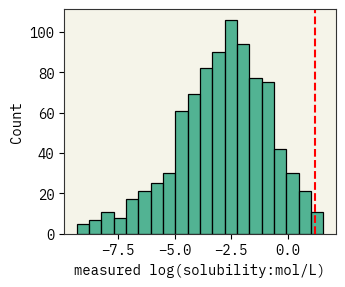

In [ ]:
import seaborn as sns

d['expected_improvement'][1][-1][1]
best = d['expected_improvement'][:, :, 1].astype(float).mean(axis=0)[-1]
print(best)

sns.histplot(raw_data[y_name])
print(np.sum(raw_data[y_name] > best))
plt.axvline(best, color='red', linestyle='--')
plt.show()


### Alloy

In [ ]:
import pandas as pd
import numpy as np

np.random.seed(0)

data_path = "paper/data/yield_strength.csv"
raw_data = pd.read_csv(data_path)
# raw_data = raw_data.sample(frac=1).reset_index(drop=True)

print(raw_data.columns)

N = raw_data.shape[0]
indexes = np.random.choice(raw_data.shape[0], int(N), replace=False)
# shuffle test

print(N, len(indexes))

asktell = bolift.AskTellFewShotTopk(
    prefix="",
    prompt_template=PromptTemplate(
        input_variables=["x", "y", "y_name"],
        template="Q: What is the {y_name} of {x}?@@@\nA: {y}###",
    ),
    suffix="What is the {y_name} of {x}?@@@\nA:",
    # x_formatter=lambda x: f"alloy composition: {x}",
    y_name="yield strength",
    y_formatter=lambda y: f"{y:.2f}",
    model="gpt-4",
    selector_k=5,
)


x_name = "composition"
y_name = "yield strength"


In [ ]:
N = 10
M = 5
starts = np.random.randint(0, len(indexes), M)
plt.figure(figsize=(3.5, 3.5 / 1.2))
random_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="random",
        start_index=starts[i],
    )
    random_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C0", alpha=0.1)
# plot mean
random_points = np.array(random_points)
plt.plot(
    range(N + 1),
    random_points[:, :, 1].astype(float).mean(axis=0),
    color="C0",
    label="Random",
)

greedy_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="greedy",
        start_index=starts[i],
    )
    greedy_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C2", alpha=0.1)
# plot mean
greedy_points = np.array(greedy_points)
plt.plot(
    range(N + 1),
    greedy_points[:, :, 1].astype(float).mean(axis=0),
    color="C2",
    label="Greedy",
)

ei_points = []
for i in range(M):
    point = run_experiment(
        asktell,
        raw_data,
        indexes,
        x_name,
        y_name,
        N=N,
        aq="expected_improvement",
        start_index=starts[i],
    )
    ei_points.append(point)
    plt.plot(range(N + 1), [y for x, y in point], color="C1", alpha=0.1)
# plot mean
ei_points = np.array(ei_points)
plt.plot(
    range(N + 1), ei_points[:, :, 1].astype(float).mean(axis=0), color="C1", label="EI"
)

plt.axhline(y=raw_data["yield strength"].min(), color="C0", linestyle="--", label="min")
plt.axhline(
    y=raw_data["yield strength"].mean(), color="C1", linestyle="--", label="mean"
)
plt.axhline(y=raw_data["yield strength"].max(), color="C2", linestyle="--", label="max")
# give 5% quantiles
plt.axhline(
    y=raw_data["yield strength"].quantile(0.05), color="C3", linestyle="--", label="5%"
)
plt.axhline(
    y=raw_data["yield strength"].quantile(0.95), color="C4", linestyle="--", label="95%"
)

plt.xlabel("Samples")
# reduce number of ticks
# plt.xticks([0, 5, 10])
# plt.ylim(-10, 0)
# plt.yticks(np.linspace(-10, 0, 3))
plt.legend(loc="center left", bbox_to_anchor=(1.05, 0.5))
plt.savefig("concept_multi.png", dpi=300)